# Python Perfomance Options

Python is a programming language that is chosen often for the easy and forgiving syntax.
Unfortunately, as we will see, the same features that make Python this easy are also the features that make it very slow compared to many other languages.

We will discuss a few options on how to speed up calculations.

Before we begin, I want to point out what we will not be discussing here. 
We will not be discussing File I/O -- i.e. how to make the program read or write data from/to disk faster. 
There are very few things you can do once the hardware is in place to speed up that process, and for the few cases where there might be a difference to be made, other tutorials will talk about that.

We will also not be discussing parallelisation and dask, which can be used to speed up the computation, but is discussed widely elsewhere.
This post will be discussing on how to overcome the inherent performance issues with Python itself.

## Example Challenge: Interpolation

To compare different methods, we will have different methods to perform the same task: A linear interpolation of a large array.

That is, we will have three arrays:

- `X0` - The x-components of the initial dataset
- `Y0` - The corresponding y-component, so it must have the same length as `X0`.
- `X1` - The new x-components that we want to interpolate to.

And we want to get the y-components `Y1`, that correspond to the values of `X1` and follow the same procedure.

For ease of use, we will look at a sine wave, interpolated to a smaller and shifted grid.

### Verification
We will verify that we get the same values by calling the numpy function `allclose()` on the arrays to check whether they're all the same.
Note that it's usually not a good idea to compare floating point variables for absolute identity, as changing the order of operations might cause different rounding errors that lead to every so small differences in the actual values.

We will use the `assert` keyword, which does nothing at all if the allclose returns `True`, but will leave a big `AssertionError` if allclose returns `False`.

### Timing
We will be using the [Python `timeit` package](https://docs.python.org/3/library/timeit.html) to evaluate how quickly the computation runs. 
This method runs the code several times, and averages the results.

```python
result = %timeit -o some_complex_function() ## This will be timed
```
We collect these results in a dictionary for comparison at the end.


## Native Python

To get a baseline for the performance, we will start with doing it all in Python natively.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, pi
from typing import List
from nptyping import NDArray, Shape, Float64  ## Will be used for type hinting later
sns.set_theme()
timings = {}

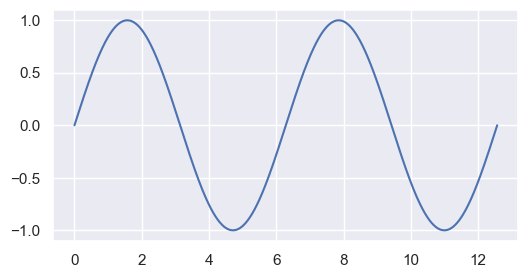

In [2]:
N0 = 100_000
X0 = [(4.0 * pi / N0) * i for i in range(N0)]
Y0 = [sin(x) for x in X0]

N1 = 40_000
X1 = [(3.0 * pi / N1) * i + 1e-4 for i in range(N1)]

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(X0, Y0)
plt.show()

In [3]:
## Note that I'm using type hints here.
## They will have no effect on the code's performance
## or behaviour, but make it more understandable.
def single_interp(x0: float, y0: float, x1: float, y1: float, x: float) -> float:
    y = (y0 * (x1 - x) + y1 * (x - x0)) / (x1 - x0)
    return y

def interp(X1: List[float], X0: List[float], Y0: List[float]) -> List[float]:
    idx0 = 0 
    Y1 = [0.0] * len(X1)
    for idx1, x1 in enumerate(X1):
        while X0[idx0] < x1:
            idx0 += 1
        if X0[idx0] == x1:
            Y1[idx1] = Y0[idx0]
        else:
            Y1[idx1] = single_interp(X0[idx0 - 1], Y0[idx0 - 1], X0[idx0], Y0[idx0], X1[idx1])
    return Y1

timings['python'] = %timeit -o interp(X1, X0, Y0)

Y1_python = interp(X1, X0, Y0)

6.88 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As you can see, on my computer this has taken about 7 ms on average.
This might not seem like much, but if we have a multi-dimensional array, this will take some time.

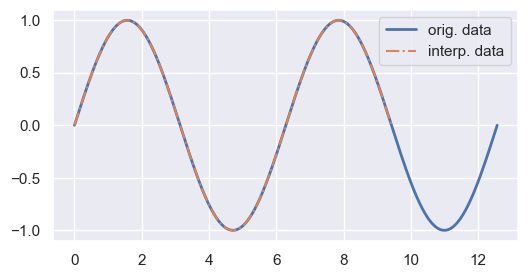

In [4]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(X0, Y0, linewidth=2, label='orig. data')
ax.plot(X1, Y1_python, '-.', label='interp. data')
ax.legend()
plt.show()

## Using numpy

Lists aren't the most performant way to store arrays of constant type inside Python.
For those items, numpy was created.

Numpy is the backbone of most of the often-used computation routines, including `scipy`, `dask`, and `xarray`.

In [5]:
import numpy as np
X0 = np.array(X0, dtype=np.float64)
Y0 = np.array(Y0, dtype=np.float64)
X1 = np.array(X1, dtype=np.float64)

As it happens, `numpy` has an interpolation routine already implemented.
Using it is pretty straightforward:

In [6]:
timings['numpy'] = %timeit -o np.interp(X1, X0, Y0)

Y1_numpy = np.interp(X1, X0, Y0)
assert np.allclose(Y1_python, Y1_numpy)

712 µs ± 320 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can see that the numpy calculation took a bit more than half a Millisecond, an order of magnitude faster than our own list implementation.

If such an option is availalbe for your use case, this is where you should stop. 
Numpy is generally coded efficiently and you will spend a lot of time coding to get a little bit more performance out of it.

But for the reminder of the post, we will assume that our task is too unusual to find such an implementation, or we will be running it hundreds of thousands of times, and we will need to create our own.
We will still continue to use numpy as the array, though.

## Scipy
If `numpy` doesn't deliver the method we are seeking, we should have a closer look at `scipy`. 
This package comes with such a wide range of scientifically important methods that we will almost always find a method that we can use.

Looking at the [ScPy Documentation](https://docs.scipy.org/doc/scipy/index.html), we can find an `interpolate` section that contains the method `interp1d`, which does what we want.

In [7]:
from scipy.interpolate import interp1d

interpolator = interp1d(X0, Y0, kind='linear')
timings['scipy'] = %timeit -o interpolator(X1)

Y1_scipy = interpolator(X1)
assert np.allclose(Y1_numpy, Y1_scipy)

748 µs ± 669 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Note that the developers behind `scipy` have decided to [depreciate the `interp1d` method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) in favour of the `numpy.interp` method described above.
This section is only intended to show that `scipy` offers a wide range of optimised calculations on numeric arrays.


## Numba

Numba has been specifically to 'Just In Time' compile functions for added performance.
It is used by adding the Numba Just In Time `@jit` [decorator](https://realpython.com/primer-on-python-decorators/) before the function declaration.

This makes numba compile the code before execution, making it much, much faster.

You can read more about Numba [here](https://numba.pydata.org).

In [8]:
from numba import jit

@jit
def single_interp_numba(x0: np.float64, y0: np.float64, x1: np.float64, y1: np.float64, x: np.float64) -> np.float64:
    y = (y0 * (x1 - x) + y1 * (x - x0)) / (x1 - x0)
    return y

@jit
def interp_numba(
    X1: NDArray[Shape["N1"], Float64], 
    X0: NDArray[Shape["N0"], Float64], 
    Y0: NDArray[Shape["N0"], Float64]
    ) -> NDArray[Shape["N1"], Float64]:
    idx0 = 0 
    Y1 = np.empty_like(X1)
    for idx1, x1 in enumerate(X1):
        while X0[idx0] < x1:
            idx0 += 1
        if X0[idx0] == x1:
            Y1[idx1] = Y0[idx0]
        else:
            Y1[idx1] = single_interp_numba(X0[idx0 - 1], Y0[idx0 - 1], X0[idx0], Y0[idx0], X1[idx1])
    return Y1

In [9]:
timings['numba'] = %timeit -o interp_numba(X1, X0, Y0)

Y1_numba = interp_numba(X1, X0, Y0)
assert np.allclose(Y1_numpy, Y1_numba)

97.3 µs ± 2.84 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In this particular case, the computation was again 7 times faster than even the `numpy.interp` call. 
To be honest, this is a bit surprising, and I suspect that this is due to the numpy routine making some edge case checks that our code here simply ignores.

## Pre-Compiled Code

There are interfaces to write code in compiled programming languages, and call them from within python.

As an example, we will look at a fortran subroutine.

### Fortran

To run fortran from within Jupyter, we can install the fortran-magic package with either `pip` or `conda`:
```bash
pip install fortran-magic
```

Then we load the extension by executing the magic:

In [10]:
%load_ext fortranmagic

After this, we can mark a cell with `%%fortran` to ensure that the contents of that cell get compiled and made available as a function.
Let's check it out.

In [11]:
%%fortran
subroutine interp_fortran(X1, X0, Y0, Y1, n0, n1)
    implicit none

    real*8, intent(in) :: X1(n1), X0(n0), Y0(n0)
    real*8, intent(out) :: Y1(n1)
    integer, intent(in) :: n0, n1
    integer :: idx0, idx1

    idx0 = 1 
    Y1 = 0.0_8
    do idx1 = 1, n1
        do while (X0(idx0) < X1(idx1) .and. idx0 < n0)
            idx0 = idx0 + 1
        end do
        if (X0(idx0) == X1(idx1)) then
            Y1(idx1) = Y0(idx0)
        else
            Y1(idx1) = single_interp(X0(idx0 - 1), Y0(idx0 - 1), X0(idx0), Y0(idx0), X1(idx1))
        end if
    end do
contains
    function single_interp(xs0, ys0, xs1, ys1, xs) result(ys)
        implicit none

        real*8, intent(in) :: xs0, ys0, xs1, ys1, xs
        real*8 :: ys

        ys = (ys0 * (xs1 - xs) + ys1 * (xs - xs0)) / (xs1 - xs0)
    end function single_interp
end subroutine interp_fortran

The %%fortran magic makes it very convenient to have everything inside a single notebook.
But you can also save the fortan code in a separate file, for example `lib_interp.f90`, 
then run the shell command:

```bash
python -m numpy.f2py -c lib_interp.f90 -m lib_interp
```

This creates a new module called `lib_interp`, which can be imported:

```python
from lib_interp import interp_fortran
```

Also note that the code uses the archaic and actually non-standard `real*8` declaration for double precision floating point numbers.
`f2py` gets confused when using the correct `c_double` (from `iso_c_binding`) or `real64` (from `iso_fortran_env`) kind declarators.
Ask me how I know.

In [12]:
timings['fortran'] = %timeit -o interp_fortran(X1, X0, Y0)

Y1_fortran = interp_fortran(X1, X0, Y0)
assert np.allclose(Y1_numba, Y1_fortran)

79.1 µs ± 783 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In this case, I chose Fortran as the language of the compiled code, but there are ways to program the functions in other ways, for example in [C](https://realpython.com/build-python-c-extension-module/) and [Rust](https://github.com/PyO3/pyo3).

## Mojo

You might have heard about Mojo, a new language that aims to be a superset of python, but fast.
But to achieve the promised speed improvements, mojo has to step away from weakly typed, interpreted, reflective python syntax.
At this point this language is volatile and far from production ready. 
To get the promised speed improvements, one needs to rewrite practically everything.
It is probably worth keeping it on the radar, but I would advise against spending too much time on it at this point in time.

## Conclusion

We have looked at different ways how to improve the computation performance of our Python code.

- **Numpy** is already the backbone of our calculations, and comes with a lot of operations on these arrays pre-build.
  It's reasonably efficient and often enough for what we want to do.
- **Scipy** is a package with a quite large amount of scientifically relevant functions and routines.
  There's almost always a method fitting for the task.
- **Numba** can be used to translate python code into machine code and execute that compiled code. 
  This can lead to really large performance increases.
- **Compiling own code** means writing code in another, compiled, language like Fortran, C, or Rust. 
  This can give us a lot of control over the execution, and will likely lead to very good performance.
- **Mojo** is a project that we should keep on our radar, but at the moment it's not ripe for use.
  The idea is to bring together the ease of use of python with the performance of a compiled language.
  There are smart people with lofty goals working on it, but whether that's even possible is not yet known.

Let's have a look at a comparison of the results of the interpolation:

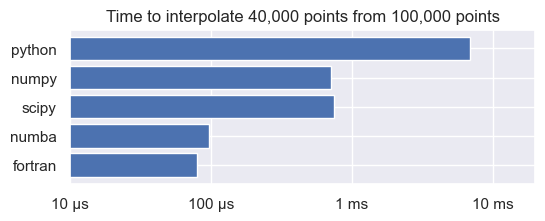

In [13]:
fig, ax = plt.subplots(figsize=(6, 2))
methods = list(reversed(('python', 'numpy', 'scipy', 'numba', 'fortran')))
values = [timings[method].average for method in methods]
ax.barh(methods, values)
ax.set_xscale('log')
ax.set_xlim(1e-5,0.02)
ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
ax.set_xticklabels(['10 µs', '100 µs', '1 ms', '10 ms'])
ax.set_title(f"Time to interpolate {N1:,d} points from {N0:,d} points")
plt.show()